# Kaggle Intro to SQL (and BigQuery)
- https://www.kaggle.com/learn/intro-to-sql

## 5. As & With
- Organize your query for better readability. This becomes especially importan for complex queries.

### Introduction

- With all that you've learned, your SQL queries are getting pretty long, which can make them hard understand (and debug).
- You are about to learn how to use AS and WITH to tidy up your queries and make them easier to read.

### AS - aliasing

- To use AS in SQL, insert it right after the column you select.

``` Python:
query = '''
    SELECT Animal, COUNT(ID)
    FROM `bigquery-public-data.pet_records.pets`
    GROUP BY Animal '''

query = '''
    SELECT Animal, COUNT(ID) AS number
    FROM `bigquery-public-data.pet_records.pets`
    GROUP BY Animal '''
```

### WITH... AS

- AS is more powerful when combined with WITH in what's called a CTE
- CTE, a common table expression, is a temporary table that you return within your query.
- CTEs are helpful for splitting your queries into readable chunks, and you can write queries against them.

``` Python:
query = '''
    WITH Seniors AS
    (
        SELECT ID, Name
        FROM `bigquery-public-data.pet_records.pets`
        WHERE Years_old > 5
    )
    SELECT ID
    FROM Seniors '''
```
- You could do this without a CTE, but if this were the first part of a very long query, removing the CTE would make it much harder to follow. -- later in the exercise I will do both cases: with and without CTE.
- Also, it's important to note that CTEs only exist inside the query where you create them, and you can't reference them in later queries. So, any query that uses a CTE is always broken into two parts: (1) first, we create the CTE, and then (2) we write a query that uses the CTE.

### Example: How many Bitcoin transactions are made per month?

- We're going to use a CTE to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.
- We'll investigate the transactions table. Here is a view of the first few rows. (The corresponding code is hidden, but you can un-hide it by clicking on the "Code" button below.)

In [1]:
from google.cloud import bigquery

# Create a "Client" object
#client = bigquery.Client('jmProject86385')
client = bigquery.Client('jmproject86385')

# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
client.list_rows(table, max_results=5).to_dataframe()

C:\Users\jm\anaconda3\envs\KglSQL_1\lib\site-packages\google\auth\_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
C:\Users\jm\AppData\Local\Temp\ipykernel_10344\3985716981.py:20: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  client.list_rows(table, max_results=5).to_dataframe()


,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


- Since the block_timestamp column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the DATE() command.
- We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.

In [2]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


- Since they're returned sorted, we can easily plot the raw results to show us the number of Bitcoin transactions per day over the whole timespan of this dataset.
- transaction_by_date IS a DataFrame - easy to plot

<Axes: xlabel='trans_date'>

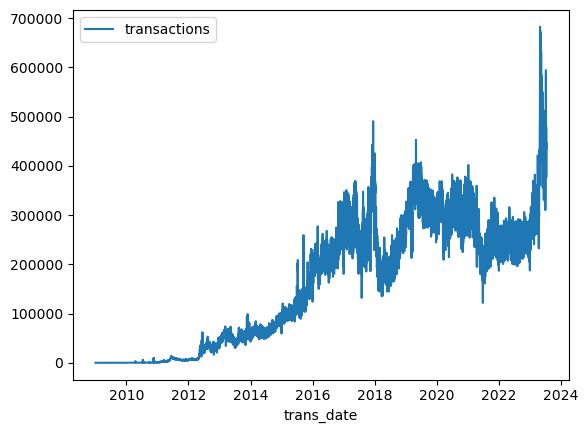

In [3]:
#import matplotlib.pyplot as plt

transactions_by_date.set_index('trans_date').plot()

### JM both cases: with and without CTE

In [4]:
# Query to select the number of transactions per date, sorted by date
q_CTE_1 = """
    SELECT COUNT(1) AS transac, EXTRACT(DATE from block_timestamp) AS t_date
    FROM `bigquery-public-data.crypto_bitcoin.transactions`
    GROUP BY t_date
    ORDER BY t_date """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(q_CTE_1, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,transac,t_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


### JM another case using CTE
- transacs for all the octubers

In [7]:
# Group all the octubers transacs
q_CTE_2 = '''
    SELECT COUNT(1) AS transac, EXTRACT(MONTH from block_timestamp) AS month
    FROM `bigquery-public-data.crypto_bitcoin.transactions`
    GROUP BY month
    ORDER BY month '''

    # SELECT *, EXTRACT(MONTH from block_timestamp) AS month
    # FROM `bigquery-public-data.crypto_bitcoin.transactions`
    # WHERE month = 10 '''

    # WITH only_octs AS
    # (
    #     SELECT *, EXTRACT(MONTH from block_time) AS month,
    #     FROM `bigquery-public-data.crypto_bitcoin.transactions`
    #     WHERE month = 10
    # )
    # SELECT *
    # FROM only_octs
    # ORDER BY month """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(q_CTE_2, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_m = query_job.to_dataframe()

# Print the first five rows
transactions_by_m

,transac,month
0,75218859,1
1,69394660,2
2,73261242,3
3,74249893,4
4,83489178,5
5,74600099,6
6,70301805,7
7,65459664,8
8,64511680,9
9,68967811,10


In [6]:
# Group all the octubers transacs
# q_CTE_2 = """ 
#     WITH only_octs AS
#     (
#         SELECT *,
#             EXTRACT(MONTH from block_time) AS month,
#             EXTRACT(YEAR from block_time) AS year,
#         FROM `bigquery-public-data.crypto_bitcoin.transactions`
#         WHERE month = 10
#     )
#     SELECT COUNT(1) AS transac
#     FROM only_octs
#     GROUP BY month
#     ORDER BY year """

# # Set up the query (cancel the query if it would use too much of 
# # your quota, with the limit set to 10 GB)
# safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
# query_job = client.query(q_CTE_2, job_config=safe_config)

# # API request - run the query, and convert the results to a pandas DataFrame
# transactions_by_date = query_job.to_dataframe()

# # Print the first five rows
# transactions_by_2.head()